<a href="https://www.kaggle.com/code/oakthyago/photovoltaic-analysis-from-full-of-shadows-system?scriptVersionId=110236819" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Introduction
This dataset was get from a client photovoltaic system.  Bellow is a photo of the system espesification. This particular client has a lot obcjects applying shadows on the photovolcaic modules and is a very particular case to be analised.



![a](https://i.postimg.cc/8cz5xZny/paulino.png)

In [2]:
df = pd.read_csv("../input/solarenergynortheastbrazil/2_Paulino_newdata.csv")
df["Single Plate Ambient Temperature"] = df.iloc[:, 38] #the original columns was not working when called by name

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26757 entries, 0 to 26756
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           26757 non-null  int64  
 1   Device Type                          26757 non-null  object 
 2   SN                                   26757 non-null  object 
 3   Parent Device                        26757 non-null  int64  
 4   Time                                 26757 non-null  object 
 5   Hardware Version                     26757 non-null  object 
 6   Master Software Version              26757 non-null  object 
 7   Vice Software Version                26757 non-null  object 
 8   Standard Main Version                26757 non-null  int64  
 9   Communication CPU Software Version   26757 non-null  object 
 10  DC Voltage PV1(V)                    26757 non-null  float64
 11  DC Voltage PV2(V)           

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,Device Type,SN,Parent Device,Time,Hardware Version,Master Software Version,Vice Software Version,Standard Main Version,Communication CPU Software Version,DC Voltage PV1(V),DC Voltage PV2(V),DC Current PV1(A),DC Current PV2(A),DC Power PV1(W),DC Power PV2(W),Total Power Generation(W),AC Voltage R/U/A(V),AC Current R/U/A(A),AC Output Frequency R(Hz),Total AC Output Power(W),Cumulative Production (Active)(kWh),Daily Production (Active)(kWh),Dc Component- Phase R Current(mA),Total Reactive Power(W),Ppc Ac Current R(A),Ppc Ac Power R(W),Grid Status,Total Grid Power(W),Leak Current(mA),Insulation Impedance 1(KΩ),Combiner Voltage-Group 1(V),String Current- Group 1 Line 1(A),String Current- Group 1 Line 2(A),Combiner Voltage-Group 2(V),String Current- Group 2 Line 1(A),String Current- Group 2 Line 2(A),Total Consumption Power(W),Single Plate Ambient Temperature(℃),Radiator Temperature 1(℃),System Time,Generation Time Today(Min),Generation Time Total(Min),Total Running Hour(h),Boot Countdown,Bus Voltage(V),Inverter status,Slave Address,Single Plate Ambient Temperature
0,0,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:16:58,V001,V000000,V000000,0,V030001,0.0,0.0,0.00,0.00,0.0,0.0,0,0.0,0.00,0.00,0.0,116.8,0.0,0,0.0,0.00,0.0,Static,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2022-05-07 05:16:31,0,5943,101.27,0,0.0,Waiting,NaN,0
1,1,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:22:04,V200,V030006,V030001,601,V030001,152.6,152.6,0.41,0.57,60.0,80.0,140,218.8,0.07,60.02,0.0,116.8,0.0,0,0.0,0.41,0.0,Static,0.0,2,0,152.7,0.0,0.0,152.6,0.0,0.0,0.0,36,25,2022-05-07 05:21:44,0,5943,101.35,201,151.2,Waiting,NaN,36
2,2,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:27:08,V200,V030006,V030001,601,V030001,160.2,160.2,0.42,0.56,60.0,90.0,150,222.8,0.08,59.98,0.0,116.8,0.0,0,0.0,0.41,0.0,Static,0.0,3,0,160.2,0.0,0.0,160.2,0.0,0.0,0.0,37,25,2022-05-07 05:26:53,0,5943,101.43,213,158.7,Waiting,NaN,37
3,3,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:32:13,V200,V030006,V030001,601,V030001,132.2,136.3,0.10,0.14,10.0,10.0,20,218.6,0.56,59.96,20.0,116.8,0.0,-1,0.0,0.39,0.0,Static,0.0,5,787,136.2,0.0,0.0,132.2,0.0,0.0,0.0,37,25,2022-05-07 05:32:04,1,5944,101.53,180,349.9,Grid connected,NaN,37
4,4,Inverter,SH3ES250MB8301,2309721222,2022/05/07 05:37:19,V200,V030006,V030001,601,V030001,144.2,140.3,0.30,0.33,40.0,40.0,80,224.7,0.20,59.96,30.0,116.8,0.0,-1,0.0,0.38,0.0,Static,0.0,8,787,144.2,0.0,0.0,140.3,0.0,0.0,0.0,38,26,2022-05-07 05:37:13,6,5949,101.62,180,358.8,Grid connected,NaN,38


<AxesSubplot:>

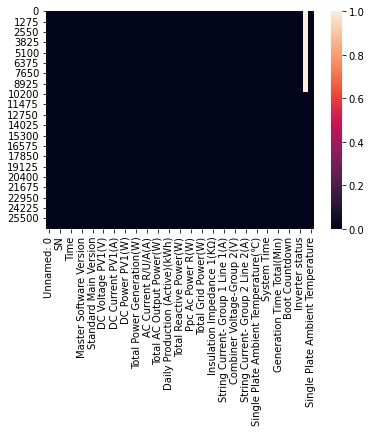

In [5]:
#to see if the dataset has some null values
sns.heatmap(df.isnull())


In [6]:
#sns.pairplot(df)

In [7]:
df['Date'] = df['Time'].apply(lambda x: x.split(' ')[0])
df['Hour'] = df['Time'].apply(lambda x: x.split(' ')[1])
df["Time"] = pd.to_datetime(df["Time"])

In [8]:
calendar_dc = df.pivot_table(values='DC Power PV1(W)', index='Time', columns='Date')

In [9]:
df2 = pd.read_csv("../input/solarenergynortheastbrazil/2_Sevem_Marcelo_new_data.csv")
df2['Date'] = df2['Time'].apply(lambda x: x.split(' ')[0])
df2['Hour'] = df2['Time'].apply(lambda x: x.split(' ')[1])

<AxesSubplot:>

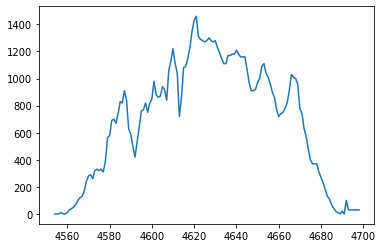

In [10]:
df[df["Date"] == "2022/06/07"]["Total AC Output Power(W)"].plot()

In [11]:
#sns.jointplot(x='Hour', y="Total AC Output Power(W)",data=df2)

<AxesSubplot:>

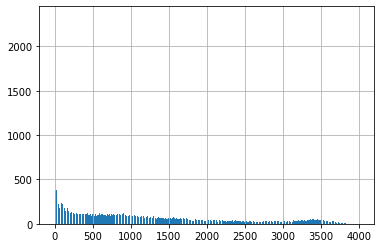

In [12]:
df["Total AC Output Power(W)"].hist(bins=500)

In [13]:
corr_matrix=df.corr()
corr_matrix["Total AC Output Power(W)"].sort_values(ascending=False)

Total AC Output Power(W)               1.000000
AC Current R/U/A(A)                    0.999398
DC Power PV1(W)                        0.994282
DC Power PV2(W)                        0.993464
DC Current PV1(A)                      0.991589
DC Current PV2(A)                      0.991576
Ppc Ac Current R(A)                    0.848853
Radiator Temperature 1(℃)              0.761727
Single Plate Ambient Temperature(℃)    0.636220
Single Plate Ambient Temperature       0.636220
AC Voltage R/U/A(V)                    0.323895
Bus Voltage(V)                         0.316159
Combiner Voltage-Group 2(V)            0.268108
DC Voltage PV2(V)                      0.267659
DC Voltage PV1(V)                      0.264907
Combiner Voltage-Group 1(V)            0.264764
AC Output Frequency R(Hz)              0.093956
Standard Main Version                  0.093556
Generation Time Total(Min)             0.078492
Total Running Hour(h)                  0.078487
Unnamed: 0                             0

## Those are the more corelected columns with the power output of the system. It's true that the product of corrent and voltage should be correlected with the power. Its good to resume the dataframe and colect only the columns with some information to work.

Total AC Output Power(W)              
AC Current R/U/A(A)                   
DC Power PV1(W)                       
DC Power PV2(W)                        
DC Current PV1(A)                      
DC Current PV2(A)                     
Ppc Ac Current R(A)                    
Radiator Temperature 1(℃)              
Single Plate Ambient Temperature(℃)    
AC Voltage R/U/A(V)                    
Bus Voltage(V)                        
Combiner Voltage-Group 2(V)            
DC Voltage PV2(V)                      
DC Voltage PV1(V)                      
Combiner Voltage-Group 1(V)            

In [14]:
#here we select this columns
df=df[["Time","Date","Hour","Total AC Output Power(W)","AC Current R/U/A(A)","DC Power PV1(W)","DC Power PV2(W)","DC Current PV1(A)","DC Current PV2(A)","Ppc Ac Current R(A)","Radiator Temperature 1(℃)","Single Plate Ambient Temperature","AC Voltage R/U/A(V)","Bus Voltage(V)","Combiner Voltage-Group 2(V)","DC Voltage PV2(V)","DC Voltage PV1(V)","Combiner Voltage-Group 1(V)"]]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26757 entries, 0 to 26756
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Time                              26757 non-null  datetime64[ns]
 1   Date                              26757 non-null  object        
 2   Hour                              26757 non-null  object        
 3   Total AC Output Power(W)          26757 non-null  float64       
 4   AC Current R/U/A(A)               26757 non-null  float64       
 5   DC Power PV1(W)                   26757 non-null  float64       
 6   DC Power PV2(W)                   26757 non-null  float64       
 7   DC Current PV1(A)                 26757 non-null  float64       
 8   DC Current PV2(A)                 26757 non-null  float64       
 9   Ppc Ac Current R(A)               26757 non-null  float64       
 10  Radiator Temperature 1(℃)         26757 non-nu

In [16]:
df

,Time,Date,Hour,Total AC Output Power(W),AC Current R/U/A(A),DC Power PV1(W),DC Power PV2(W),DC Current PV1(A),DC Current PV2(A),Ppc Ac Current R(A),Radiator Temperature 1(℃),Single Plate Ambient Temperature,AC Voltage R/U/A(V),Bus Voltage(V),Combiner Voltage-Group 2(V),DC Voltage PV2(V),DC Voltage PV1(V),Combiner Voltage-Group 1(V)
0,2022-05-07 05:16:58,2022/05/07,05:16:58,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-07 05:22:04,2022/05/07,05:22:04,0.0,0.07,60.0,80.0,0.41,0.57,0.41,25,36,218.8,151.2,152.6,152.6,152.6,152.7
2,2022-05-07 05:27:08,2022/05/07,05:27:08,0.0,0.08,60.0,90.0,0.42,0.56,0.41,25,37,222.8,158.7,160.2,160.2,160.2,160.2
3,2022-05-07 05:32:13,2022/05/07,05:32:13,20.0,0.56,10.0,10.0,0.10,0.14,0.39,25,37,218.6,349.9,132.2,136.3,132.2,136.2
4,2022-05-07 05:37:19,2022/05/07,05:37:19,30.0,0.20,40.0,40.0,0.30,0.33,0.38,26,38,224.7,358.8,140.3,140.3,144.2,144.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26752,2022-11-02 16:56:46,2022/11/02,16:56:46,10.0,0.19,30.0,20.0,0.22,0.17,0.39,38,51,218.5,349.5,140.2,144.2,140.4,140.2
26753,2022-11-02 17:01:50,2022/11/02,17:01:50,0.0,0.38,20.0,10.0,0.18,0.11,0.40,38,50,220.8,353.1,132.2,132.2,136.5,136.5
26754,2022-11-02 17:06:54,2022/11/02,17:06:54,10.0,0.43,10.0,10.0,0.10,0.09,0.42,38,50,220.6,352.4,148.6,144.1,152.4,148.5
26755,2022-11-02 17:11:58,2022/11/02,17:11:58,0.0,0.35,10.0,0.0,0.09,0.04,0.42,38,50,219.5,351.6,128.4,128.4,140.5,140.5


Its necessáry to round the time in 5 to 5 minutes samples and get the mean if there is two or more sample in the same time

In [17]:
df["Time"] = pd.Series(df["Time"]).dt.round(freq='5T')
df["Hour"] = df.Time.dt.time #
df["Hour_srt"] = df["Hour"].astype(str) 

<Figure size 1152x576 with 0 Axes>

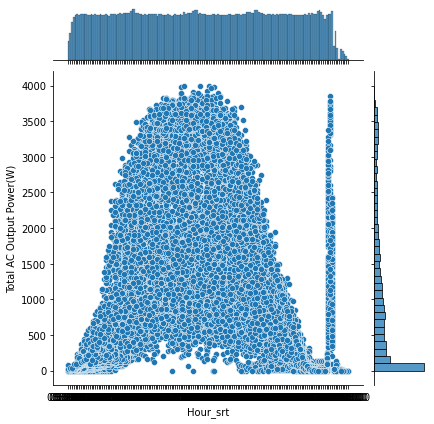

In [18]:
from matplotlib import pyplot as plt
plt.show()
plt.figure(figsize=(16,8))
sns.jointplot(x='Hour_srt', y="Total AC Output Power(W)",data=df)
